<a href="https://colab.research.google.com/github/butchland/deeplearning-fastai-experiments/blob/master/nbs/fastai_PlantVintage-1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fast AI Image Classification using Mixed Precision and Progressive Resizing



##Background

This notebook is based on a [jupyter notebook](https://github.com/aayushmnit/fastai_v3_experimentation/blob/master/Lesson-1-PlantVintage.ipynb) by Aayush Agrawal which was modified to be run in [**Colab**](https://colab.research.google.com),  a free platform for deep learning research and education.

This uses the **Plant Village dataset** to try to achieve world class results as quickly as possible using [**fast.ai**](https://docs.fast.ai/)'s _mixed precision_ capabilities
as well as _progressive resizing_ techniques suggested by
**[Jeremy Howard](https://twitter.com/jeremyphoward)** in the [Practical Deep Learning for Coders forum](https://forums.fast.ai/search?q=progressive%20resizing)  and [class](https://course.fast.ai) discussions.

The dataset used is the  [PlantVillage Dataset](https://plantvillage.psu.edu/). 

The **PlantVillage** dataset has images of plant leaves which consist of 38 disease classes which are commonly found on crops  and one background class from Stanford's open dataset of background images - [DAGS](http://dags.stanford.edu/projects/scenedataset.html).

The dataset was  downloaded from links given on [this Github Repo](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases) as the original notebook suggested.

The actual  preprocessed dataset can be downloaded from [here](https://drive.google.com/open?id=0B_voCy5O5sXMTFByemhpZllYREU).

It might also be useful to compare the results achieved here with the [other results](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases#results) collated by the original author [Marko Arsenovic](https://github.com/MarkoArsenovic) for the book  [Deep Learning for Plant Diseases: Detection and Saliency Map Visualisation](https://link.springer.com/chapter/10.1007/978-3-319-90403-0_6)



## Conclusions (TLDR; )

- _Possible_ State of the Art Accuracy Record (as of March 2019) : **99.8001 percent** (see [this](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases#results) for comparison)
- Low number of training epochs: 36
- Low memory requirements: Max GPU Memory 11 GB, Average 3-4 GB for first 2 stages
- Average to Medium Training Time on a low end hardware (Nvidia K80):   6.36 hrs
- Platform: Colab with GPU


 - **Yes, you can get SOTA results on free DL platforms using FastAI, mixed precision, progressive resizing and simple fine tuning using the fastai learning rate finder.**
 
 - ** I have not been able to find updates to the published accuracy records since 2017 so this record still needs to be verified**

## Some Notes about the Notebook

 - In order to be able to reproduce the steps quickly, the data and the intermediate models were backed up into and restored from  Google Drive (using Colab's integration with google drive) 
 - Due to Colab's memory resource allocation limits, the kernel was always restarted after every training run or after running the Learning Rate finder or even the classification interpretation.
 - Also,  since the notebook was run over several sessions, when each session was terminated, the files (data and intermediate models) were deleted, so before each session (or even after every training run), the intermediate models were backed into Google Drive.
 - In addition to `.pth` formats, the intermediate and final models were also exported as `.pkl` files and backed up into Google Drive so they can be used for inference later.

### Setup Colab Environment for Fastai

Install latest fastai version, create standard directories (`/content/data` and `/content/models`) and delete the default `sample_data` directory created by **Colab**.

**DONT FORGET TO SET RUNTIME TYPE TO GPU**

In [2]:
# !curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   2018      0 --:--:-- --:--:-- --:--:--  2018
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


Run magic directives to autoreload and inline matplots

In [0]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

## Connect Colab to Google

Since I already created a shared file link (using Google Drive) to the original dataset), I can use this link to later copy the data into my Colab data directory. 

The nice thing about the shared file link is that it doesn't use up my own personal Google Drive quota (as the dataset is quite large even in compressed format).


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)

### Importing Fast AI library

In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
__version__

'1.0.50.post1'

## Set some useful variables and utility functions



I store my backup data and models in the folders `/fastai_v3/data` and `/fastai_v3/models` so that I can reproduce my work and also sometimes reduce the need to rebuild the data and models I am studying.

In [0]:
gdrive = Path('/content/gdrive/My Drive/fastai_v3')

In [0]:
escdrive = lambda x : x.as_posix().replace(' ','\ ') # useful utility to escape spaces

### Load the dataset

In [0]:
dataset = 'PlantVillage'

Copy compressed dataset into the work data directory

In [0]:
# !cp {escdrive(gdrive/'data'/(dataset + '.tar.gz'))} {Config.data_path()}

Decompress the data (remove the verbose in tar option as the listing can be very large and might cause the page to hang)

In [0]:
# !tar xzf {(Config.data_path()/(dataset + '.tar.gz')).as_posix()} -C {Config.data_path()}

## Setup Default Metrics, Path,  Image Size and Transforms

Set metrics for tracking stats while training the model

In [0]:
metrics = [error_rate, accuracy]

Set the path of the dataset

In [6]:
## Declaring path of dataset
path_img = Config.data_path()/dataset; path_img

PosixPath('/root/.fastai/data/PlantVillage')

Set default image size to 224

In [0]:
default_size=224

Setup transforms

In [0]:
ds_tfms = get_transforms()


## Prepare Labeled Datasets

Setup labelled datasets

In [0]:
## Loading data and Normalizing data based on Image net parameters
src  = (ImageList.from_folder(path_img)
        .split_by_folder(train='train', valid='val')
        .label_from_folder())


** Skip the following section on Setting up the Databunch  if doubling in image size and kernel restarted**

##  Setup Databunch

Set batchsize

In [0]:
bs = 256 # 256 might be possible with mixed precision

Set image size (** Progressive Sizing** means train initially with small image sizes)

In [0]:
size = default_size // 2 # 112 as initial size

In [0]:
data = (src
        .transform(tfms=ds_tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

## Show Data

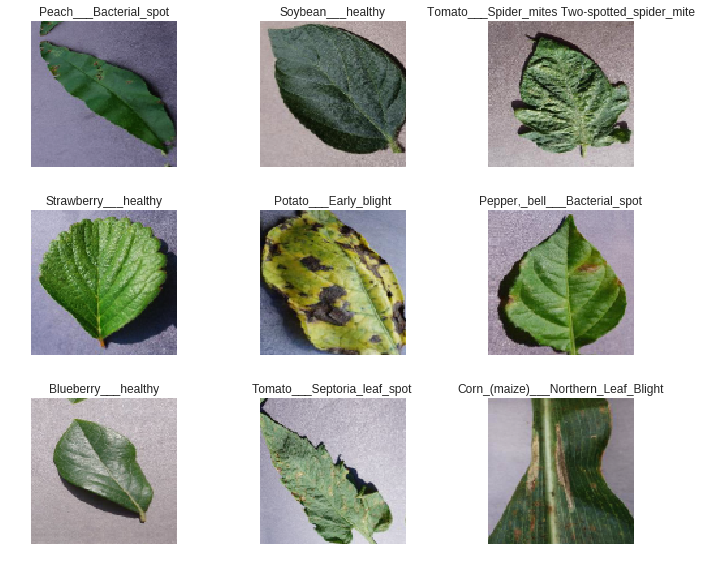

In [0]:
data.show_batch(rows=3, figsize=(10,8))

Data Classes

In [0]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

## Create Model

Create model with ResNET50

In [0]:
## To create a ResNET 50 with pretrained weights
learn = cnn_learner(data, models.resnet50, metrics=metrics)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 99988865.92it/s]


Convert to use **mixed precision**

In [0]:
## convert to use mixed precision
learn.to_fp16();

In [0]:
learn.summary()

## Train Stage 1 Model Using Frozen Model and Default Max LR 

Train using 5 epochs, max learning = 1e-3 (default)

In [0]:
learn.fit_one_cycle(5)

## Backup Stage 1 Model

Having a consistent naming scheme for the model makes it easy to version and review what it contains and how it was built.

In [0]:
model_name = 'plant-vintage-mixedprecision-stage1-fp16-sz112-bs256-resnet50-lr1e3-cycle5'

In [0]:
# learn.save(model_name)

In [0]:
# !cp {(path_img/'models'/(model_name + '.pth')).as_posix()} {escdrive(gdrive/'models')}

## Study Stage 1 Model

Review training stats

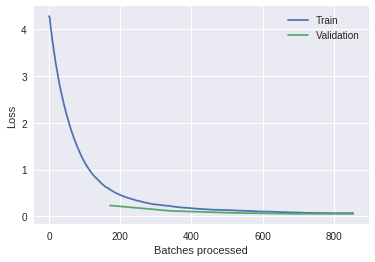

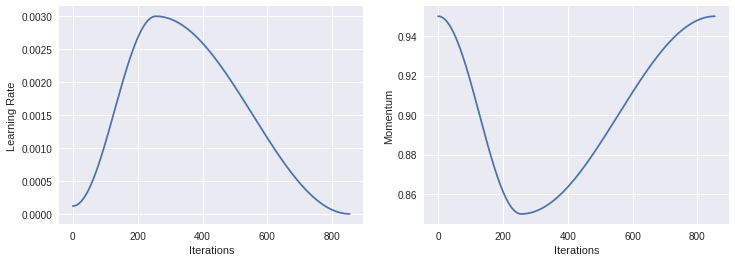

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

Convert to fp32 for interpretation

In [0]:
learn.to_fp32();

Create interpreter

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

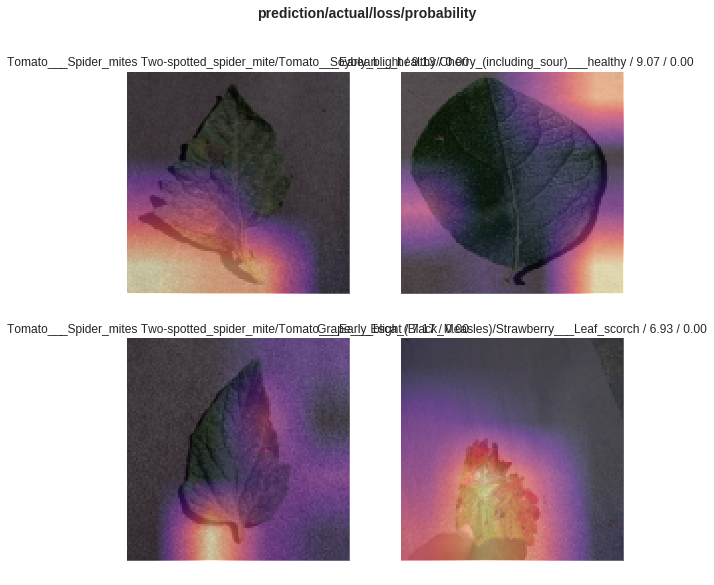

In [0]:
interp.plot_top_losses(4, figsize=(9,9))

See top right image - the model maybe activating on the background, not the leaf itself. 

It may make sense to review the quality of the training data to prevent bias since the model is starting to "learn" the wrong parts for classification.

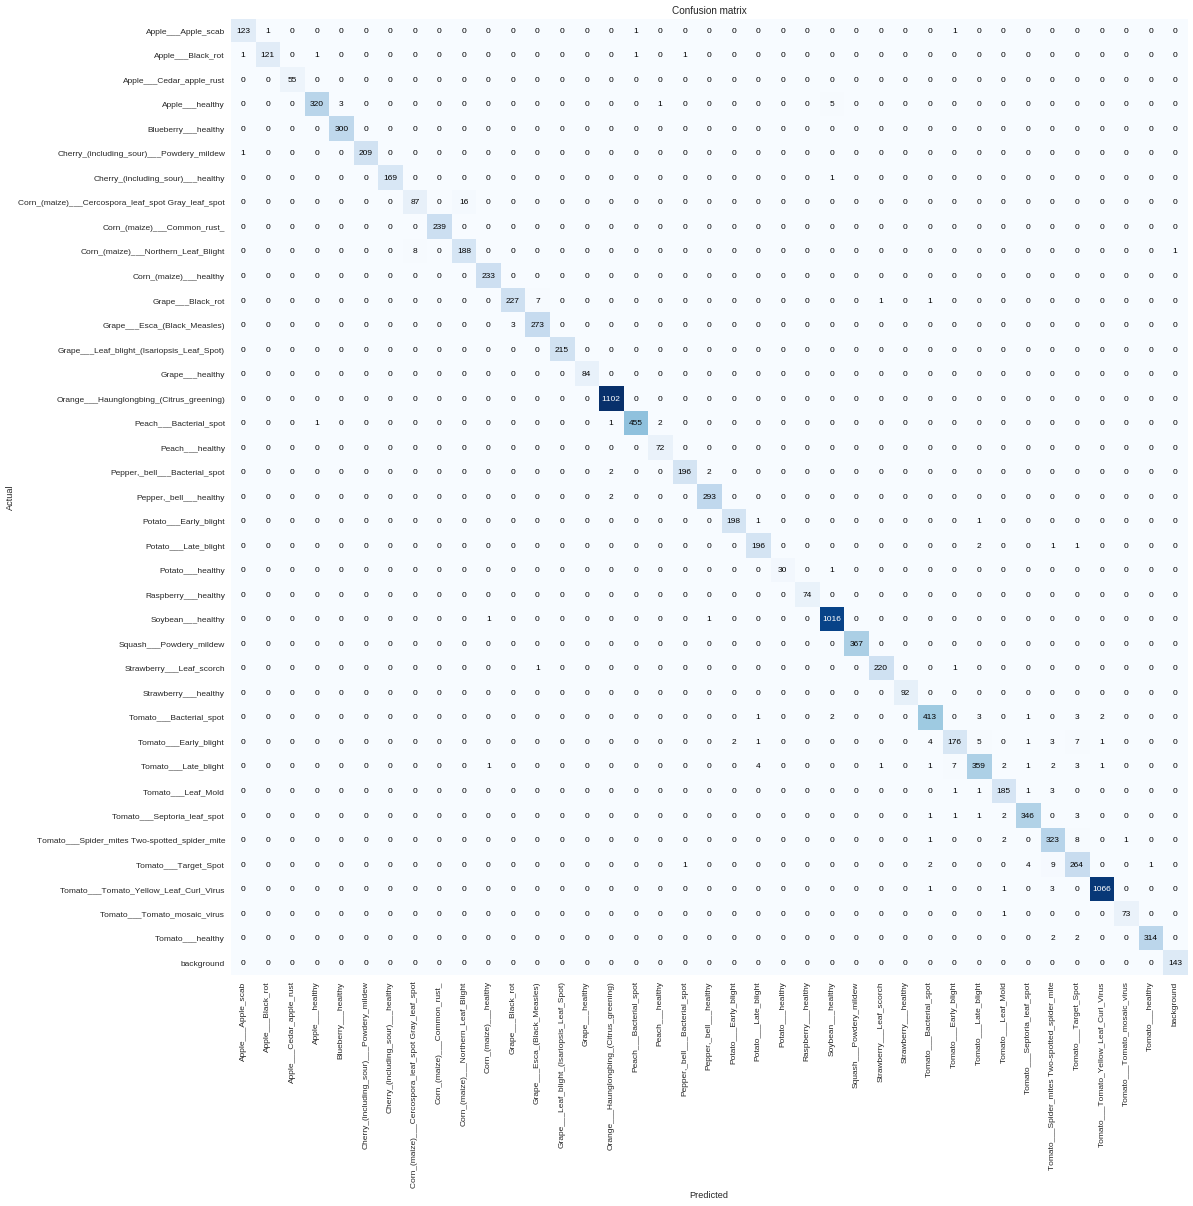

In [0]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Northern_Leaf_Blight',
  16),
 ('Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 9),
 ('Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  8),
 ('Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 8),
 ('Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 7),
 ('Tomato___Early_blight', 'Tomato___Target_Spot', 7),
 ('Tomato___Late_blight', 'Tomato___Early_blight', 7),
 ('Apple___healthy', 'Soybean___healthy', 5),
 ('Tomato___Early_blight', 'Tomato___Late_blight', 5),
 ('Tomato___Early_blight', 'Tomato___Bacterial_spot', 4),
 ('Tomato___Late_blight', 'Potato___Late_blight', 4),
 ('Tomato___Target_Spot', 'Tomato___Septoria_leaf_spot', 4),
 ('Apple___healthy', 'Blueberry___healthy', 3),
 ('Grape___Esca_(Black_Measles)', 'Grape___Black_rot', 3),
 ('Tomato___Bacterial_spot', 'Tomato___Late_blight', 3),
 ('Tomato___Bacterial_spot',

## Continue Training Model

Convert back to mixed precision for learning rate finding and further training

In [0]:
learn.to_fp16();

## Prepare Stage 2 (Unfrozen all layers)

Reload model 

In [0]:
learn.load(model_name);

## Run LR Finder

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


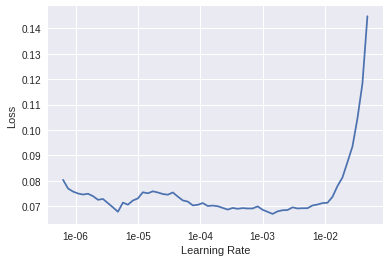

In [0]:
learn.recorder.plot()

## Unfreeze the Model for Stage 2

In [0]:
learn.unfreeze()

## Train Unfrozen Model (Stage 2) at Half-size (112x112)

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,5e-4))

## Backup Unfrozen Halfsize Model (Stage 2)

In [0]:
model_name = (model_name
              .replace('stage1','stage2')
              .replace('cycle5','cycle4')
              .replace('lr1e3','lrs1e6s5e4'))
model_name

'plant-vintage-mixedprecision-stage2-fp16-sz112-bs256-resnet50-lrs1e6s5e4-cycle4'

In [0]:
learn.save(model_name)


In [0]:
!cp {(path_img/'models'/(model_name + '.pth')).as_posix()} {escdrive(gdrive/'models')}

In [0]:
learn.export(model_name + '.pkl')

In [0]:
!cp {(path_img/(model_name + '.pkl')).as_posix()} {escdrive(gdrive/'models')}

Review training stats 

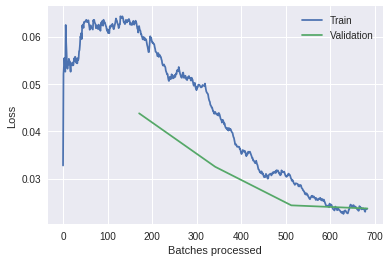

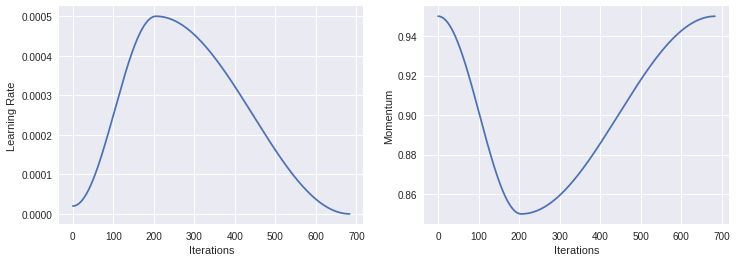

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

** RESTART KERNEL **  and Reload local variables

## Resize Image to Full and Reduce Batch Size



In [0]:
model_name = 'plant-vintage-mixedprecision-stage2-fp16-sz112-bs256-resnet50-lrs1e6s5e4-cycle4'

Copy from gdrive

In [0]:
# !cp {escdrive(gdrive/'models'/(model_name + '.pth'))}  {(path_img/'models').as_posix()}

##  Setup Databunch with Image Size Full (Default Data)

Reduce batchsize

In [0]:
bs = 128 # half of 256 might be possible with mixed precision

Set image size to default  (** Progressive Sizing** means train initially with small image sizes and retrain model on larger image size)

In [0]:
size = default_size  # 224 as progressive size

In [0]:
data = (src
        .transform(tfms=ds_tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

## Create Model with Full Data

In [0]:
## To create a ResNET 50 with pretrained weights
# learn = cnn_learner(data, models.resnet50, metrics=metrics)


Load Model trained at image size - half of default

In [0]:
# learn.load(model_name);

Set Model to mixed precision

In [0]:
# learn.to_fp16();

Freeze model to train only last layer

In [0]:
# learn.freeze()

## Run LR Finder Again

In [0]:
# learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


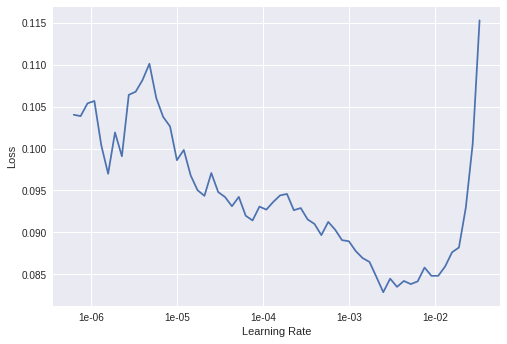

In [0]:
# learn.recorder.plot()

##Train Full Model at default rate (maxlr = 1e-3) 

In [0]:
learn.fit_one_cycle(5)

## Backup Stage 1 Fullsize (224x224) Frozen Model

In [0]:
model_name = (model_name
              .replace('stage2','stage1')
              .replace('cycle4','cycle5')
              .replace('lrs1e6s5e4','lr1e3')
              .replace('sz112','sz224')
              .replace('bs256','bs128'))
model_name

'plant-vintage-mixedprecision-stage1-fp16-sz224-bs128-resnet50-lr1e3-cycle5'

In [0]:
learn.save(model_name)


In [0]:
!cp {(path_img/'models'/(model_name + '.pth')).as_posix()} {escdrive(gdrive/'models')}

In [0]:
learn.export(model_name + '.pkl')

In [0]:
!cp {(path_img/(model_name + '.pkl')).as_posix()} {escdrive(gdrive/'models')}

Review training stats 

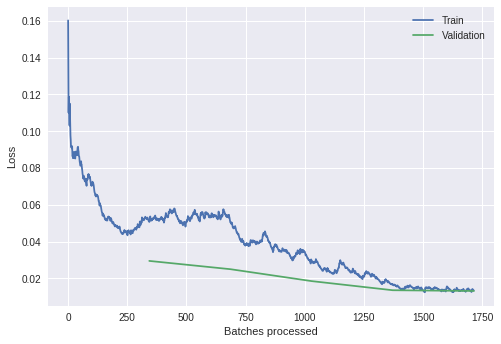

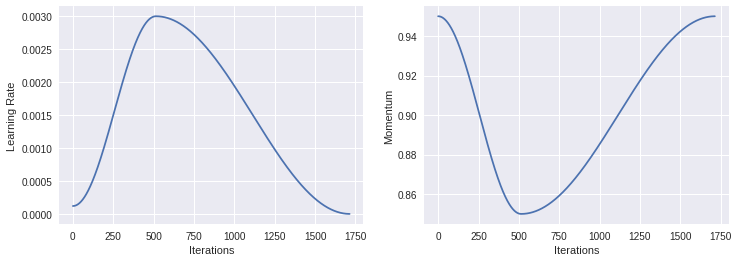

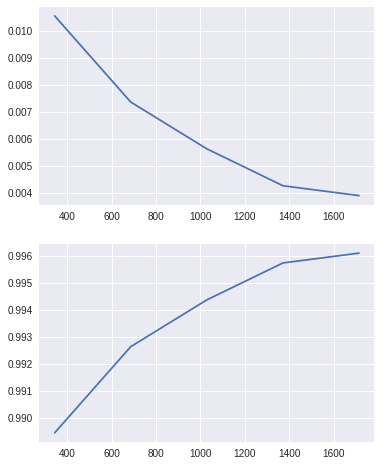

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

** RESTART KERNEL **  and Reload local variables up to Loading of Full Data (224x224)



## Reload Data and Model (Frozen Fullsize Image 224x224) 

In [0]:
model_name = 'plant-vintage-mixedprecision-stage1-fp16-sz224-bs128-resnet50-lr1e3-cycle5'

Create model

In [0]:
## To create a ResNET 50 with pretrained weights
learn = cnn_learner(data, models.resnet50, metrics=metrics)


Load Model trained at image size - full size -frozen

In [0]:
learn.load(model_name);

Set Model to mixed precision

In [0]:
learn.to_fp16();

## Run LR Finder Again

Freeze model to train only last layer

In [0]:
learn.freeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


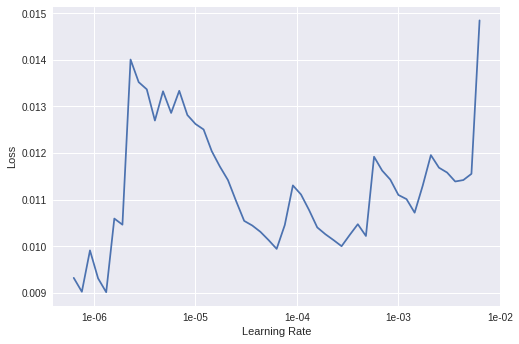

In [0]:
learn.recorder.plot()

**Might Need To Restart Kernel Again at this point**

## Unfreeze Full Size Model

In [0]:
learn.unfreeze()

## Train Full Unfrozen Model 

In [0]:
max_lr = slice(1e-6, 2e-5)

In [0]:
learn.fit_one_cycle(4,max_lr=max_lr)

## Backup Stage 2 (Unfrozen Full Size 224x224) Models

In [0]:
model_name = 'plant-vintage-mixedprecision-stage2-fp16-sz224-bs128-resnet50-lrs1e6s2e5-cycle4'

In [0]:
learn.save(model_name)


In [0]:
!cp {(path_img/'models'/(model_name + '.pth')).as_posix()} {escdrive(gdrive/'models')}

In [0]:
learn.export(model_name + '.pkl')

In [0]:
!cp {(path_img/(model_name + '.pkl')).as_posix()} {escdrive(gdrive/'models')}

Review training stats 

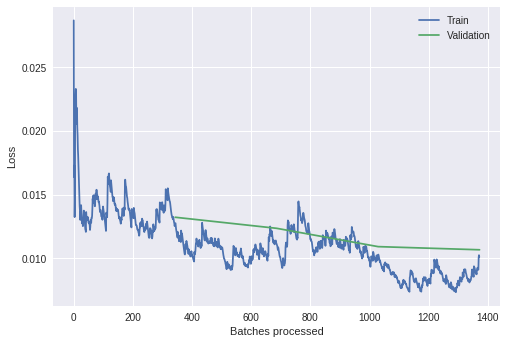

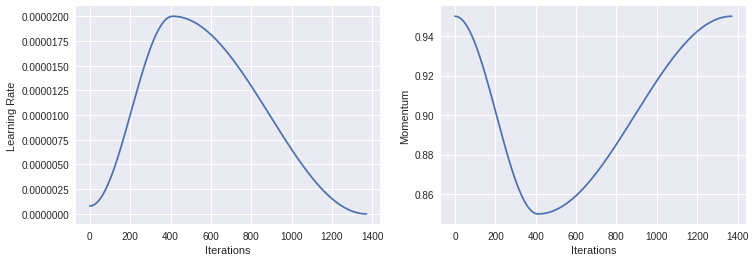

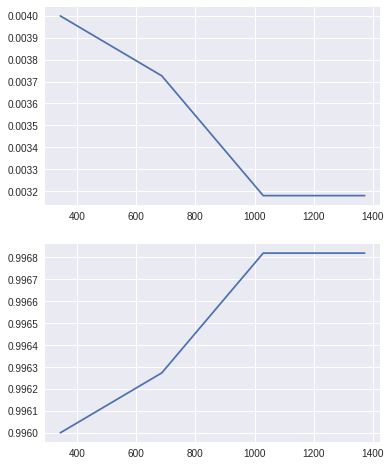

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

As we can see by training all the layers, we improved our accuracy to 99.68% (3rd highest) which is comparable to 99.76% on the [Github benchmark](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases) using Inception-v3 model.

** RESTART KERNEL **  and Reload local variables up to Loading of Full Data (224x224)



##  Setup Databunch with Image Size 1.335 x  Full (299x299)

Reduce batchsize

In [0]:
bs = 128 # half of 256 might be possible with mixed precision

Set image size (** Progressive Sizing** means train initially with small image sizes and increase image size up)

In [0]:
size = 299  # 224 * 1.335 as progressive size

In [0]:
data = (src
        .transform(tfms=ds_tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

## Create Model with Larger than Full Data

In [0]:
## To create a ResNET 50 with pretrained weights
learn = cnn_learner(data, models.resnet50, metrics=metrics)


Load Model trained at  default image size

In [0]:
model_name = 'plant-vintage-mixedprecision-stage2-fp16-sz224-bs128-resnet50-lrs1e6s2e5-cycle4'

In [0]:
learn.load(model_name);

Set Model to mixed precision

In [0]:
learn.to_fp16();

Freeze model to train only last layer

In [0]:
learn.freeze()

## Run LR Finder Again

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


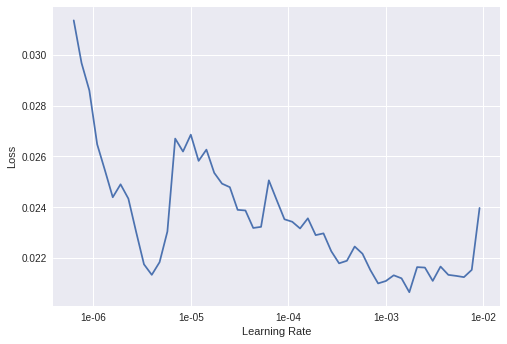

In [0]:
learn.recorder.plot()

** RESTART KERNEL **  and Reload local variables up to Loading of Full Data (224x224)



##Train Full Model at default rate (maxlr = 1e-3) 

In [0]:
learn.fit_one_cycle(5)

This 99.75 accuracy is 2nd highest!

## Backup data

In [19]:
model_name = 'plant-vintage-mixedprecision-stage1-fp16-sz299-bs128-resnet50-lr1e3-cycle5'
model_name

'plant-vintage-mixedprecision-stage1-fp16-sz299-bs128-resnet50-lr1e3-cycle5'

In [0]:
# learn.save(model_name)


In [0]:
# !cp {(path_img/'models'/(model_name + '.pth')).as_posix()} {escdrive(gdrive/'models')}

In [0]:
# learn.export(model_name + '.pkl')

In [0]:
# !cp {(path_img/(model_name + '.pkl')).as_posix()} {escdrive(gdrive/'models')}

Review training stats 

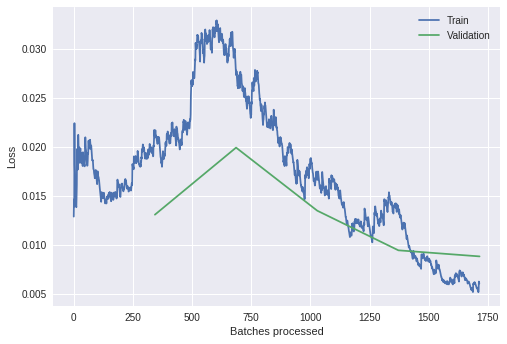

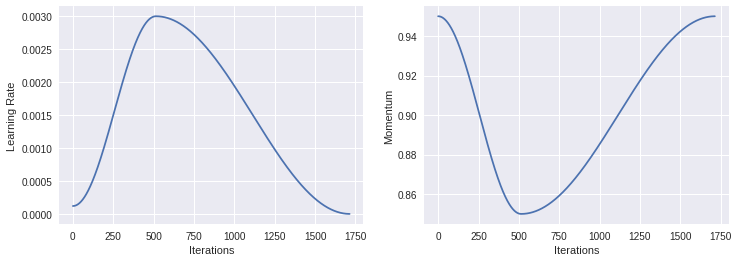

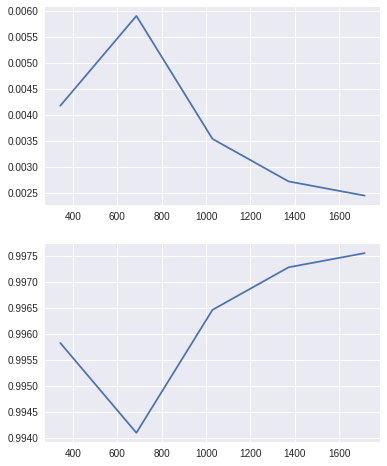

In [0]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr(show_moms=True)
# learn.recorder.plot_metrics()

** RESTART KERNEL **  and Reload local variables up to Loading of Larger than Full Data (299x299)



## Reload Data and Model (Larger than Fullsize Image 299x299) 

In [0]:
model_name = 'plant-vintage-mixedprecision-stage1-fp16-sz299-bs128-resnet50-lr1e3-cycle5'

Create model

In [0]:
## To create a ResNET 50 with pretrained weights
learn = cnn_learner(data, models.resnet50, metrics=metrics)


Copy model from backup storage

In [0]:
# (path_img/'models').mkdir(exist_ok=True)

In [0]:
# !cp  {escdrive(gdrive/'models'/(model_name + '.pth'))} {(path_img/'models').as_posix()}

Load Model trained at image size - larger than full size -frozen

In [0]:
learn.load(model_name);

Set Model to mixed precision

In [0]:
learn.to_fp16();

## Run LR Finder Again

Freeze model to train only last layer

In [0]:
learn.freeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


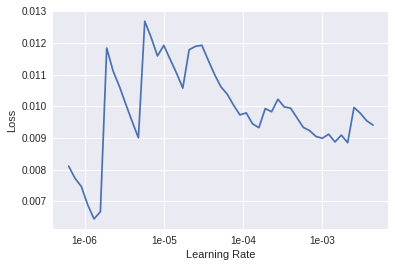

In [32]:
learn.recorder.plot()

**Might Need To Restart Kernel Again at this point**

## Unfreeze Larger than Full Size Model

In [0]:
learn.unfreeze()

## Train Larger than Full Size Unfrozen Model 

In [0]:
max_lr = slice(8e-7, 7e-5)

In [21]:
learn.fit_one_cycle(4,max_lr=max_lr)

**This 99.8001 percent accuracy is now top 1! **

## Backup data

In [0]:
model_name = 'plant-vintage-mixedprecision-stage2-fp16-sz299-bs128-resnet50-lrs8e7s7e5-cycle4'

In [0]:
learn.save(model_name)


In [0]:
!cp {(path_img/'models'/(model_name + '.pth')).as_posix()} {escdrive(gdrive/'models')}

In [0]:
learn.export(model_name + '.pkl')

In [0]:
!cp {(path_img/(model_name + '.pkl')).as_posix()} {escdrive(gdrive/'models')}

Review training stats 

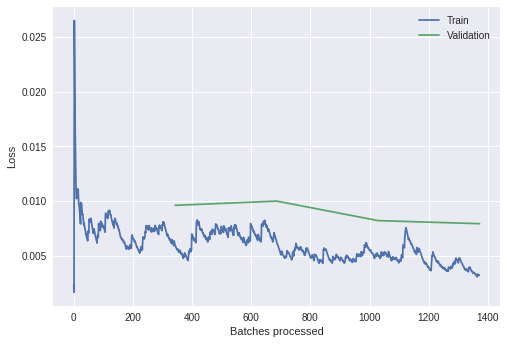

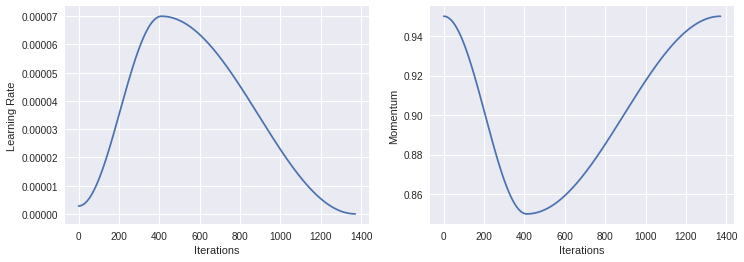

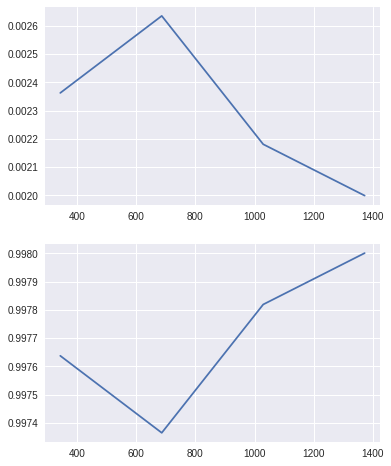

In [27]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

**RESTART Kernel and Reload Model**

## Study Stage 2 Model

## Reload Data and Model (Larger than Fullsize Image 299x299) 

In [0]:
model_name = 'plant-vintage-mixedprecision-stage2-fp16-sz299-bs128-resnet50-lrs8e7s7e5-cycle4'

Create model

In [0]:
## To create a ResNET 50 with pretrained weights
learn = cnn_learner(data, models.resnet50, metrics=metrics)


Load Model trained at image size - larger than full size -frozen

In [0]:
learn.load(model_name);

Convert to fp32 for interpretation

In [0]:
learn.to_fp32();

Create interpreter

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

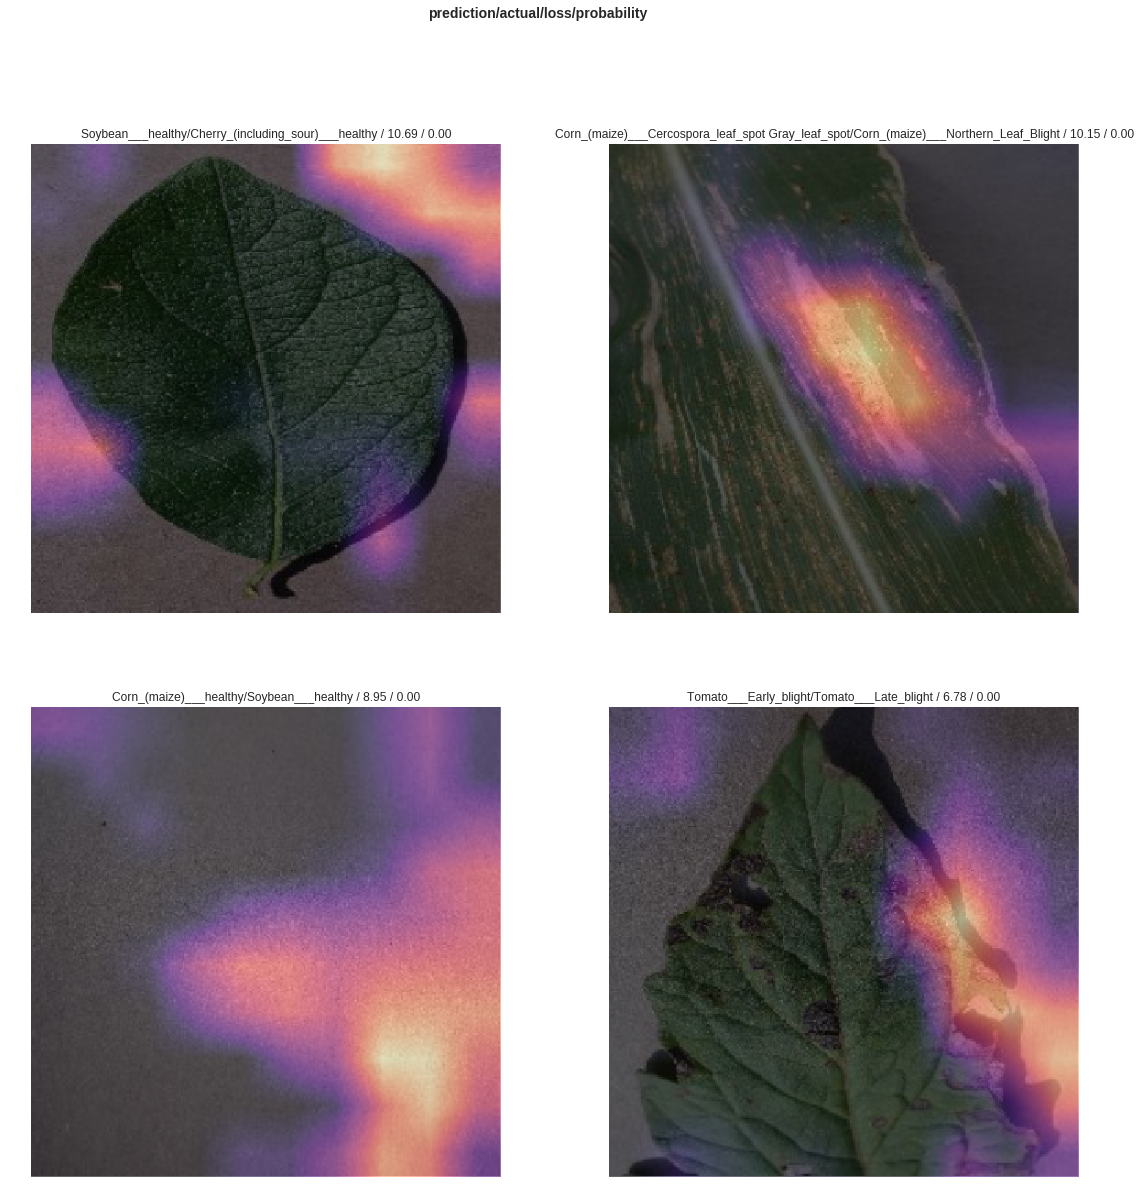

In [26]:
interp.plot_top_losses(4, figsize=(19,19))

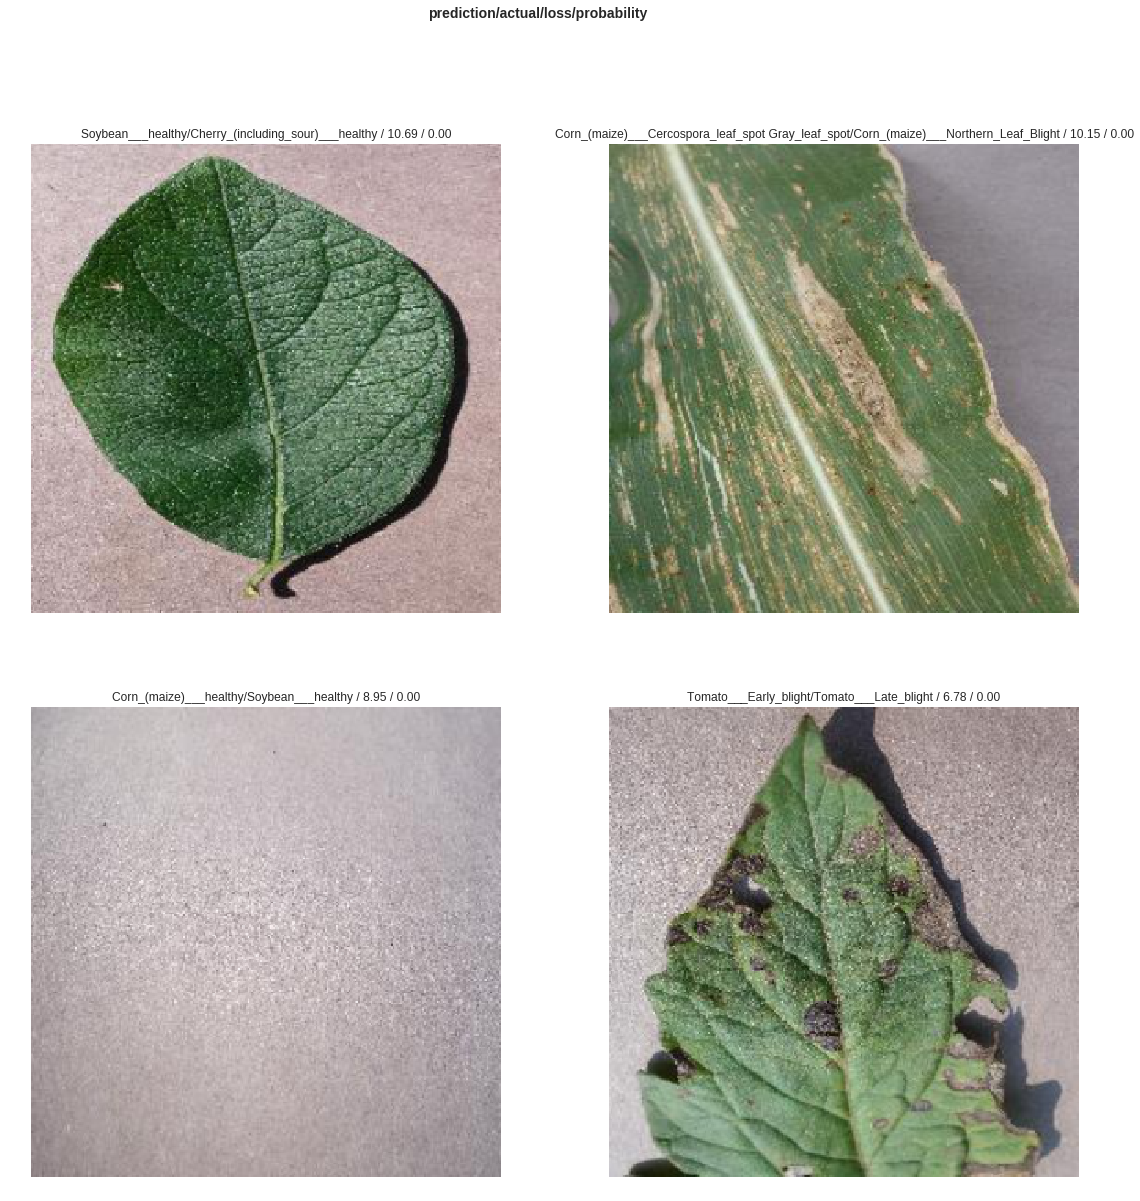

In [25]:
interp.plot_top_losses(4, figsize=(19,19),heatmap=False)

**Note that bottom row left image be an empty invalid sample (and labelled incorrectly as well!!)**

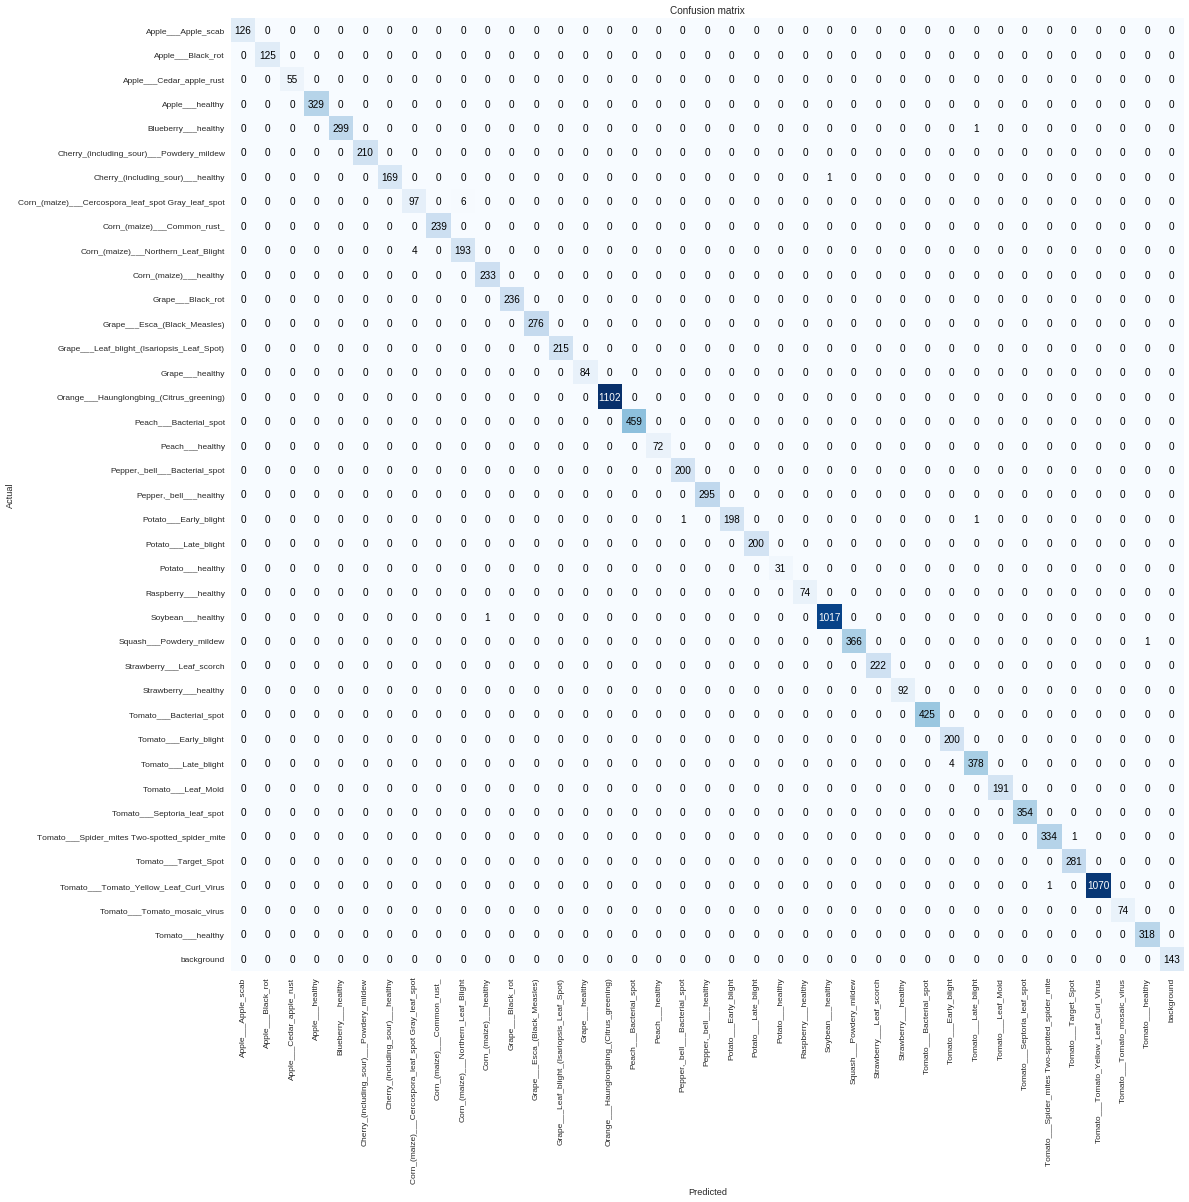

In [22]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Northern_Leaf_Blight',
  6),
 ('Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  4),
 ('Tomato___Late_blight', 'Tomato___Early_blight', 4)]

## Summary

Using Superconvergence(built-in to fastai version 1.0),  Progressive Resizing, Mixed Precision and some basic fine tuning technique using the Learning Rate finder,
the fastai model _may have been_ able to establish a **new state of the art record accuracy of 99.8001** using Colab, a free DL platform (as of March 2019).


The model was trained using small sized epochs (4-5 epochs per stage) and used a maximum of 11GB GPU Memory, averaging around 3-4 GB for the first two steps (image sizes 112x112 and 224x224).

The following steps were used to create the final model:

Note: all the training was done using Mixed Precision (`learn.to_fp16()`)
except when running an interpretation, in which the model was converted to use 32bit fp (`learn.to_fp32()`)
in order to run classification interpretation steps -- for some reason,  fastai barfs when classification interpretation
is run on a mixed precision model.

1.   Use half image size of 112x112, batchsize=256
        1. Stage 1 - Frozen except last layer, train at default LR (1e-3) 
             - Best result : 0.982915
             - 5 epochs at 6 mins per epoch, total training time: 29:58 
        2. Stage 2 - Unfreeze, train with LR slice 1e-6,5e-4
             - Best result:  0.992821
             - 4 epochs at 6.3 mins per epoch, total training time: 25:22 
        
2.   Use full image size of 224x224, batchsize=128
        1. Stage 1 - Frozen except last layer, train at default LR (1e-3) 
             - Best result : 0.996092
             - 5 epochs at 11 mins per epoch, total training time: 55:17
        2. Stage 2 - Unfreeze, train with LR slice 1e-6, 2e-5
             - Best result:  0.996819
             - 4 epochs at 14.5 mins per epoch, total training time: 58:34 
             
3.   Use 1.3x full image size of 299x299, batchsize=128
        1. Stage 1 - Frozen except last layer, train at default LR (1e-3) 
             - Best result : 0.997546
             - 5 epochs at 24.5 mins per epoch, total training time:  1:43:33  
        2. Stage 2 - Unfreeze, train with LR slice 8e-7, 7e-5
             - Best result:  0.998001
             - 4 epochs at 27 mins per epoch, total training time: 1:48:37 
             
```
Total Epochs : 36
Total Training Time:  6.36 hrs
Model: ResNET50
Max GPU Memory: 11GB
```             
Another notable finding was the GPU memory usage during traing:

   - Using a batch size of 256 and image size of 112x112,  Mixed Precision used up approx. 3-4 GB GPU Memory.

   - Using a batch size of 128 and image size of 224x224, Mixed Precision used up approx 3-4 GB as well.
   - Lastly, using a batch size of 128 and image size of 299x299, Mixed Precision used around 11GB GPU Memory (triggering warnings in Colab,  but otherwise ran to comletion)

